# Regression with Kernel Density Matrices

This notebook illustrates how to use [Kernel Density Matrices](https://github.com/fagonzalezo/kdm) for regression.

In [1]:
# Uncomment to install the required packages
# !pip install git+https://github.com/fagonzalezo/kdm.git

In [1]:
import os
os.environ["KERAS_BACKEND"] = "tensorflow"

import keras
from keras import optimizers

import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

import kdm


We will use a simple example to illustrate the main steps of the method. We will generate a synthetic dataset. We will use the mean squared error (MSE) to evaluate the performance of the model. As baseline, we will use a Gaussian Process (GP) model.

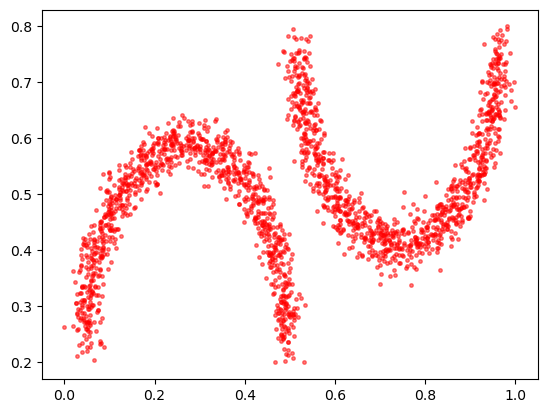

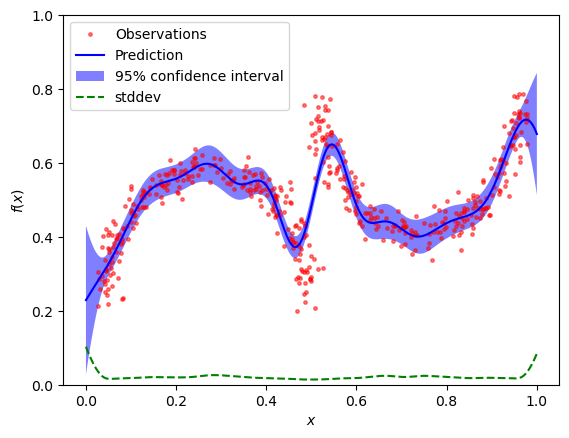

Test MSE: 0.004694631269541931


In [2]:


np.random.seed(1)

num_train_samples = 500

# create a two moons dataset
X, y = make_moons(n_samples=2000, noise=0.07)

# move the points from class two to the right and to the top
X[y == 1, 0] += 1.1
X[y == 1, 1] += 1

y = X[:, 1:]
X = X[:, :1]

scaler = MinMaxScaler((0, 1))
X = scaler.fit_transform(X)

scaler = MinMaxScaler((0.2, 0.8))
y = scaler.fit_transform(y)

# plot the dataset
plt.plot(X, y, 'r.', markersize=5, label='Observations', alpha=0.5)
plt.show()

X_train, X_test = X[:num_train_samples], X[num_train_samples:]
y_train, y_test = y[:num_train_samples], y[num_train_samples:]

# Instantiate a Gaussian Process model
kernel = ConstantKernel(1.0, (1e-3, 1e3)) * RBF(10., (1e-2, 1e2))
gp = GaussianProcessRegressor(kernel=kernel, alpha= 0.01,# dy ** 2,
                              n_restarts_optimizer=10)

# Fit to data using Maximum Likelihood Estimation of the parameters
gp.fit(X_train, y_train)

# Make the prediction on the meshed x-axis (ask for MSE as well)
x = np.atleast_2d(np.linspace(0, 1, 1000)).T
y_pred, sigma = gp.predict(x, return_std=True)

# Plot the function, the prediction and the 95% confidence interval based on
# the MSE
plt.figure()
plt.plot(X_train.ravel(), y_train, 'r.', markersize=5, label='Observations', alpha=0.5)
plt.plot(x, y_pred, 'b-', label='Prediction')
plt.fill_between(x[:,0], y_pred - 1.9600 * sigma, y_pred + 1.9600 * sigma,
         alpha=.5, fc='b', ec='None', label='95% confidence interval')

plt.plot(x[:,0], sigma, 'g--', label='stddev')

plt.xlabel('$x$')
plt.ylabel('$f(x)$')
plt.ylim(0, 1)
plt.legend(loc='upper left')

plt.show()
y_pred_test = gp.predict(X_test)

print(f"Test MSE: {mean_squared_error(y_test, y_pred_test)}")

We define functions to train a KDM regression model and to plot and evaluate the results.

In [3]:
from kdm.models import KDMRegressModel
from kdm.utils import dm_rbf_expectation, dm_rbf_variance

def train_model(n_comp=20, generative=False, epochs=1000):
    encoded_size = 1
    dim_y = 1
    encoder = keras.Sequential([keras.layers.Identity()])

    kdm_reg_model = KDMRegressModel(encoded_size=encoded_size,
                                dim_y=dim_y,
                                encoder=encoder,
                                n_comp=n_comp,
                                sigma_x=0.1,
                                sigma_y=0.1,
                                generative=generative)


    # train the model
    kdm_reg_model.compile(optimizer=optimizers.Adam(learning_rate=1e-3),
                        loss=None)
    out1= kdm_reg_model(X_train[:10])

    idx = np.random.randint(X_train.shape[0], size=n_comp)
    kdm_reg_model.init_components(X_train[idx], 
                            y_train[idx],
                            init_sigma=True)


    # Make a for to do one training step and print some loss and sigma 
    # values
    losses = []
    sigma_x = []
    sigma_y = []
    for i in range(epochs):
        history = kdm_reg_model.fit(X_train, y_train, epochs=1, batch_size=32, verbose=0)
        losses.append(history.history['loss'][0])
        sigma_x.append(keras.ops.convert_to_numpy(kdm_reg_model.kernel.sigma))
        sigma_y.append(keras.ops.convert_to_numpy(kdm_reg_model.sigma_y))

    plt.plot(losses)
    plt.title("Loss")
    plt.show()
    plt.plot(sigma_x)
    plt.title("Sigma X")
    plt.show()
    plt.plot(sigma_y)
    plt.title("Sigma Y")
    plt.show()
    return kdm_reg_model

def plot_model(kdm_model):
    # Make the prediction on the meshed x-axis (ask for MSE as well)
    rho_y = kdm_model.predict(x)
    y_pred = keras.ops.convert_to_numpy(dm_rbf_expectation(rho_y)).flatten()
    y_var = keras.ops.convert_to_numpy(dm_rbf_variance(rho_y, kdm_model.sigma_y))

    # Plot the function, the prediction and the 95% confidence interval based on
    # the MSE
    plt.figure()
    plt.plot(X_train.ravel(), y_train, 'r.', markersize=5, label='Observations', alpha=0.5)
    plt.plot(x, y_pred, 'b-', label='Prediction')

    stddev = y_var ** 0.5
    plt.fill_between(x[:,0], y_pred - 1.9600 * stddev, y_pred + 1.9600 * stddev,
            alpha=.5, fc='b', ec='None', label='95% confidence interval')
    plt.plot(x[:,0], stddev, 'g--', label='stddev')
    # plot kdm components as yellow stars
    c_x = keras.ops.convert_to_numpy(kdm_model.kdm.c_x)
    c_y = keras.ops.convert_to_numpy(kdm_model.kdm.c_y)
    c_w = keras.ops.convert_to_numpy(kdm_model.kdm.c_w)
    c_w = np.abs(c_w) / np.sum(np.abs(c_w))
    plt.scatter(c_x, c_y, s=c_w*2000, c='y', marker='o', label='KDM components')

    plt.xlabel('$x$')
    plt.ylabel('$f(x)$')
    plt.ylim(0, 1)
    plt.legend(loc='upper left')

    plt.show()
    rho_y = kdm_model.predict(X_test)
    y_pred_test = dm_rbf_expectation(rho_y)
    from sklearn.metrics import mean_squared_error

    print(f"Test MSE: {mean_squared_error(y_test, keras.ops.convert_to_numpy(y_pred_test))}")
    print(f"X_sigma: {keras.ops.convert_to_numpy(kdm_model.kernel.sigma) / np.sqrt(2)}")
    print(f"Y_sigma: {keras.ops.convert_to_numpy(kdm_model.sigma_y) / np.sqrt(2)}")
    print(f"Avg variance: {np.mean(y_var)}")


First, we train a discriminative KDM regression model with 30 components.

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


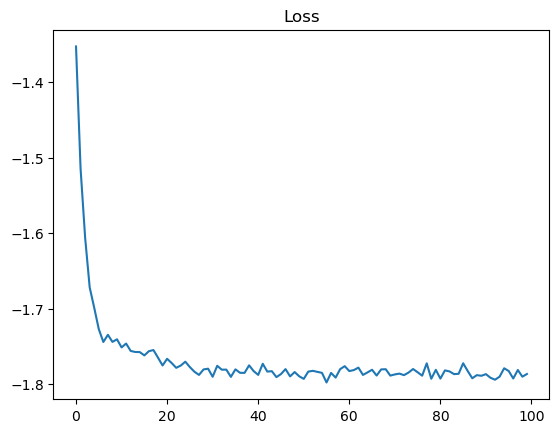

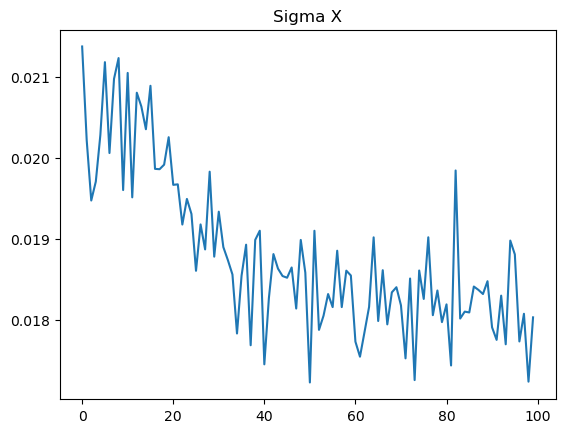

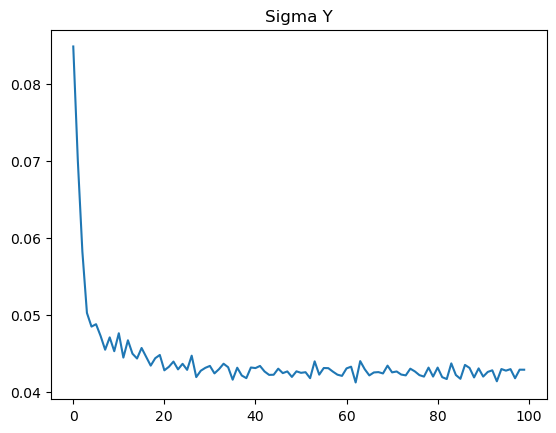

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


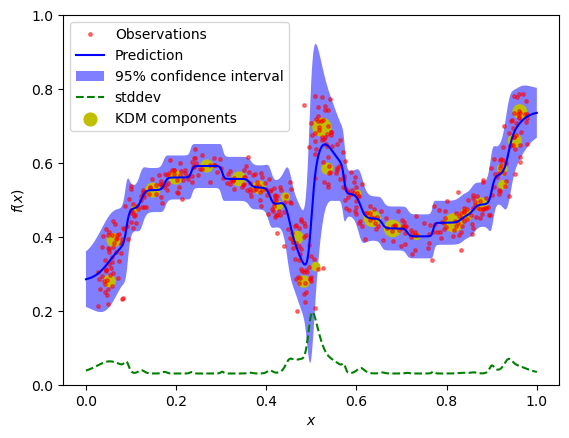

47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Test MSE: 0.004242830087429915
X_sigma: 0.012753833922748928
Y_sigma: 0.03035819849246883
Avg variance: 0.0026607532054185867


In [4]:
kdm_disc_reg_model = train_model(n_comp=30, generative=False, epochs=100)
plot_model(kdm_disc_reg_model)

Next, we train a generative KDM regression model with 30 components.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


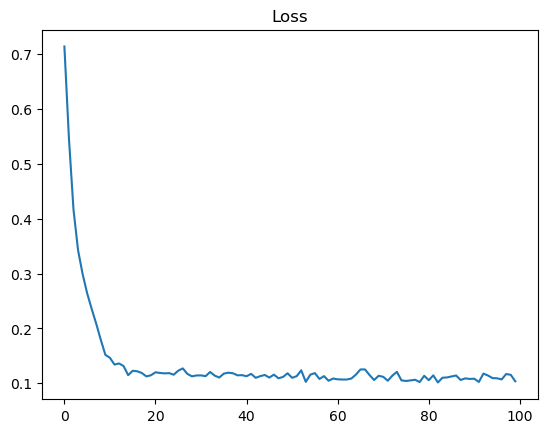

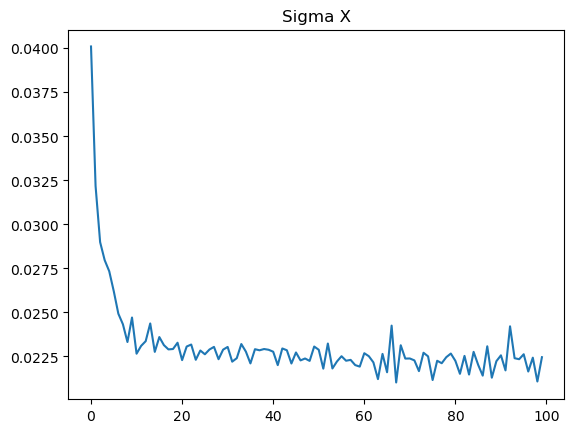

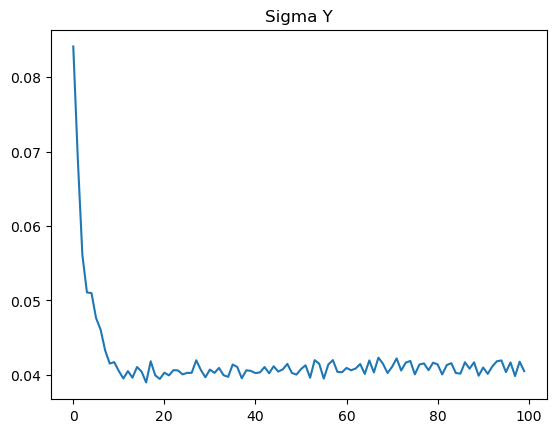

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


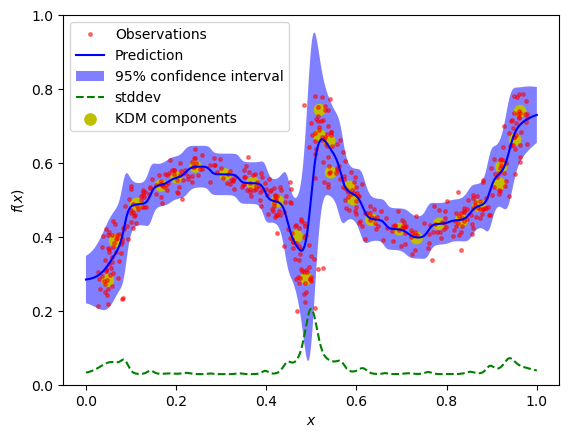

47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
Test MSE: 0.004463830005255993
X_sigma: 0.01587945079376191
Y_sigma: 0.028635783234374122
Avg variance: 0.002845136681571603


In [5]:
kdm_gen_reg_model = train_model(n_comp=30, generative=1.0, epochs=100)
plot_model(kdm_gen_reg_model)

The results show that the kdm models have a similar or better performance than the GP model in terms of MSE. The GP model is smoother than the KDM models, but the KDM models are more flexible and can capture the data distribution more accurately. The prototypes generated by the generative KDM model distribute evenly in the input space, capturing better the data distribution. The GP model seems to be overconfident in some regions, around x=0.5, where the data is sparse and has two clear modes. KDM models are better at capturing the multimodal distribution of the data.

For instance this is the prediction of the KDM models at x=0.5:

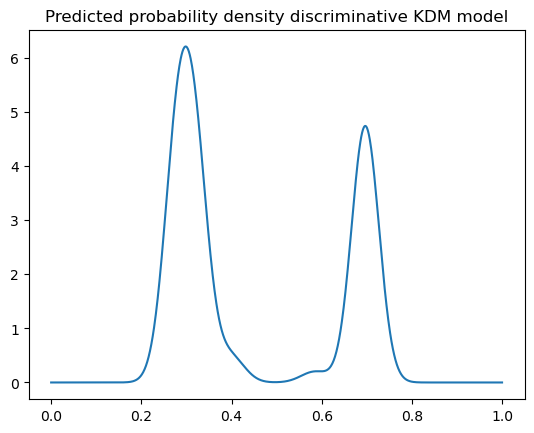

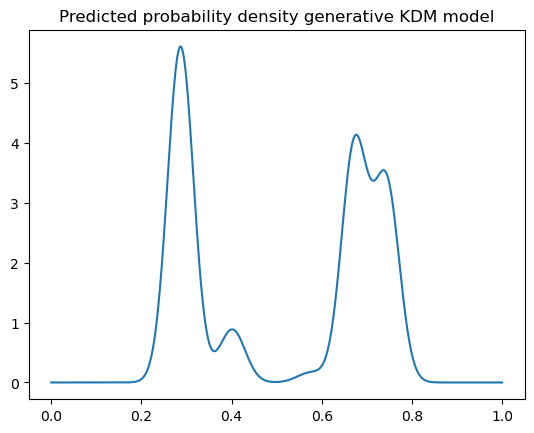

In [6]:
from kdm.utils import dm_rbf_loglik

rho_y = keras.ops.cast(kdm_disc_reg_model(np.array([[0.5]])), dtype='float32')
loglik = dm_rbf_loglik(keras.ops.convert_to_tensor(x, dtype="float32"),rho_y,kdm_disc_reg_model.sigma_y)
lik = keras.ops.convert_to_numpy(keras.ops.exp(loglik))
plt.plot(x, lik)
plt.title("Predicted probability density discriminative KDM model")
plt.show()


rho_y = keras.ops.cast(kdm_gen_reg_model(np.array([[0.5]])), dtype='float32')
loglik = dm_rbf_loglik(keras.ops.convert_to_tensor(x, dtype="float32"),rho_y,kdm_gen_reg_model.sigma_y)
lik = keras.ops.convert_to_numpy(keras.ops.exp(loglik))
plt.plot(x, lik)
plt.title("Predicted probability density generative KDM model")
plt.show()


In this plot, it is possible to clearly see the two modes of the data distribution. 

In [7]:
from kdm.utils import dm2comp
rho_y = keras.ops.cast(kdm_disc_reg_model(np.array([[10]])), dtype='float32')
w, v = dm2comp(rho_y)
print(np.sum(keras.ops.convert_to_numpy(w)))    

1.0000002
